In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [01:01<00:00, 164MB/s]
100% 5.20G/5.20G [01:01<00:00, 90.9MB/s]


In [5]:
from zipfile import ZipFile
dataset="/content/Untitled Folder/skin-cancer-mnist-ham10000.zip"
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("extracted the dataset")


extracted the dataset


In [6]:
import os
import time
import shutil
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [7]:
data_dir = '/content/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [8]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [9]:
data["label"].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [10]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [11]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [12]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2: ('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [13]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


In [15]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [17]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [18]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0

In [19]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=10 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/10
276/276 [==============================] - 298s 1s/step - loss: 1.2218 - accuracy: 0.5509 - val_loss: 1.0641 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 2/10
276/276 [==============================] - 295s 1s/step - loss: 0.5500 - accuracy: 0.8093 - val_loss: 0.4643 - val_accuracy: 0.8368 - lr: 0.0010
Epoch 3/10
276/276 [==============================] - 286s 1s/step - loss: 0.3319 - accuracy: 0.8859 - val_loss: 0.2559 - val_accuracy: 0.9115 - lr: 0.0010
Epoch 4/10
276/276 [==============================] - 295s 1s/step - loss: 0.2236 - accuracy: 0.9235 - val_loss: 0.2316 - val_accuracy: 0.9162 - lr: 0.0010
Epoch 5/10
276/276 [==============================] - 289s 1s/step - loss: 0.1662 - accuracy: 0.9430 - val_loss: 0.2037 - val_accuracy: 0.9339 - lr: 0.0010
Epoch 6/10
276/276 [==============================] - 289s 1s/step - loss: 0.1163 - accuracy: 0.9607 - val_loss: 0.1160 - val_accuracy: 0.9616 - lr: 0.0010
Epoch 7/10
276/276 [==============================] - 289s 1s/st

In [20]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

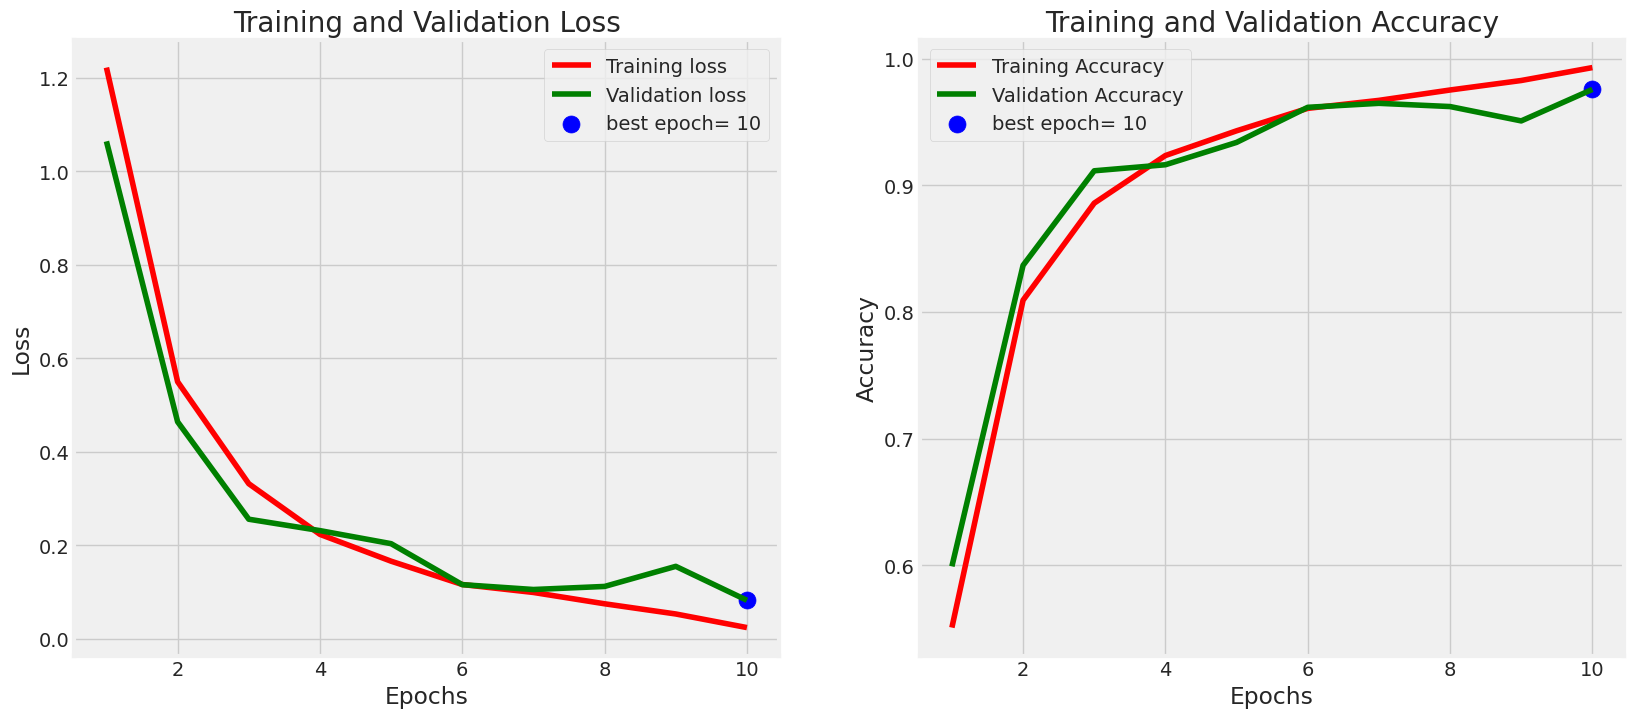

In [21]:
plot_training(history)

In [22]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 19s 53ms/step - loss: 0.0826 - accuracy: 0.9757
Train Loss:  0.009830865077674389
Train Accuracy:  0.9965057969093323
--------------------
Test Loss:  0.08256056904792786
Test Accuracy:  0.9757115840911865


In [23]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 20s 53ms/step


In [24]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


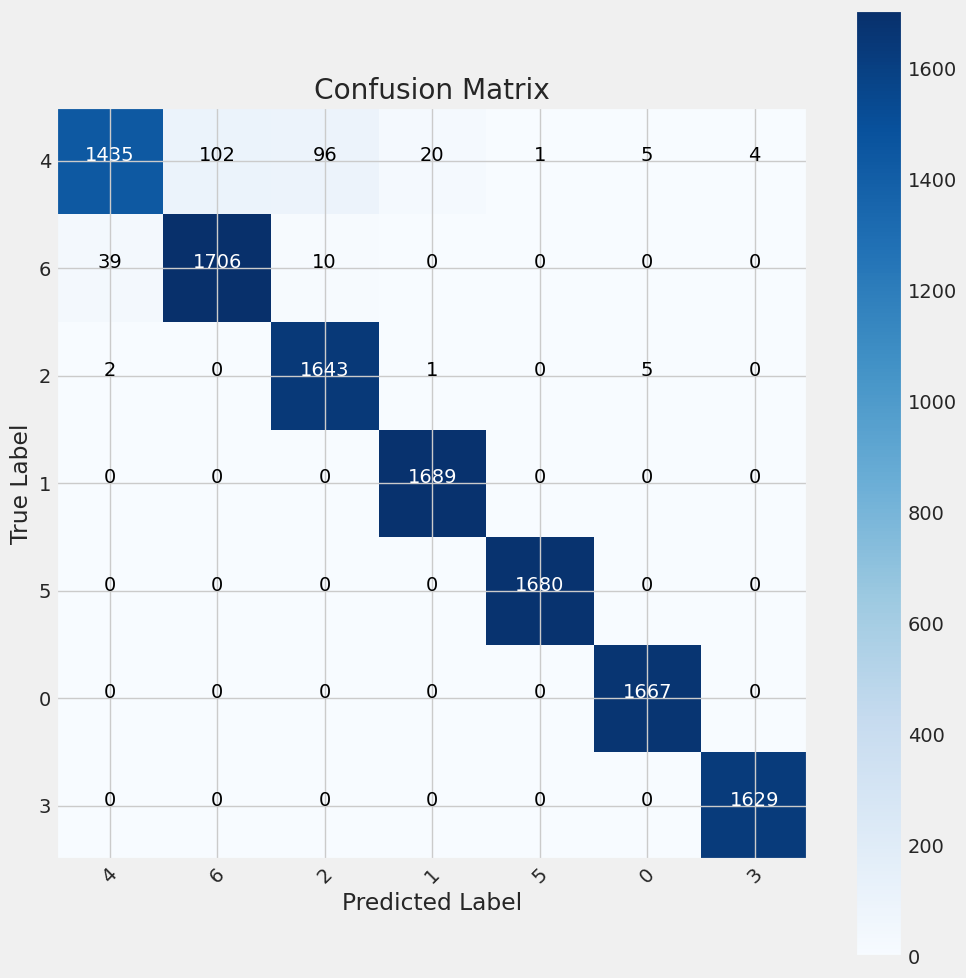

In [25]:
cm = cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [26]:
model.save('Skin desease.h5')

AttributeError: ignored

In [29]:
y_train = pd.DataFrame(y_train)

In [32]:
y_train


,0,1,2,3,4,5,6
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
35196,0.0,0.0,0.0,0.0,1.0,0.0,0.0
35197,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35198,1.0,0.0,0.0,0.0,0.0,0.0,0.0
35199,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
x_train = pd.DataFrame(x_train)

NameError: ignored

In [34]:
X_test

array([[[[172, 129, 174],
         [179, 144, 185],
         [186, 154, 196],
         ...,
         [192, 167, 194],
         [191, 165, 195],
         [187, 160, 191]],

        [[174, 132, 177],
         [182, 145, 188],
         [187, 154, 196],
         ...,
         [195, 171, 196],
         [194, 171, 198],
         [190, 166, 196]],

        [[178, 138, 182],
         [184, 147, 190],
         [189, 154, 197],
         ...,
         [197, 175, 200],
         [196, 174, 200],
         [192, 169, 199]],

        ...,

        [[177, 138, 179],
         [182, 143, 182],
         [185, 151, 188],
         ...,
         [193, 162, 196],
         [193, 159, 195],
         [187, 152, 190]],

        [[174, 136, 178],
         [180, 143, 184],
         [181, 145, 185],
         ...,
         [191, 158, 194],
         [188, 153, 189],
         [187, 153, 190]],

        [[171, 131, 174],
         [177, 139, 180],
         [179, 141, 183],
         ...,
         [188, 154, 192],
        

In [35]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('Skin desease.h5')  # Replace 'your_model.h5' with your actual model file

def preprocess_image(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (28, 28))  # Assuming your model expects 28x28 images
    image = image / 255.0  # Normalize pixel values to the range [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def get_model_output(image_path):
    preprocessed_image = preprocess_image(image_path)

    # Get the model prediction
    prediction = model.predict(preprocessed_image)

    return prediction

# Example usage
image_path = '/content/GettyImages-128554541_0-2000-c37c281914944f5db36a4d7cd1eaa6d2.jpg'  # Replace with the path to your image
output = get_model_output(image_path)

print("Model Output:", output)


1/1 [==============================] - 0s 275ms/step
Model Output: [[9.2461651e-06 1.0393815e-03 5.1850390e-01 1.1470679e-04 4.7877255e-01
  8.5991377e-04 7.0032041e-04]]


In [36]:
classes = {
    4: ('nv', 'melanocytic nevi'),
    6: ('mel', 'melanoma'),
    2: ('bkl', 'benign keratosis-like lesions'),
    1: ('bcc', 'basal cell carcinoma'),
    5: ('vasc', 'pyogenic granulomas and hemorrhage'),
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
    3: ('df', 'dermatofibroma')
}

model_output = output

# Get the predicted class label
predicted_class_index = np.argmax(model_output)
predicted_class_label, class_description = classes[predicted_class_index]

# Get the corresponding probability
predicted_probability = model_output[0][predicted_class_index]

print(f"Predicted Class: {predicted_class_label} - {class_description}")
print(f"Predicted Probability: {predicted_probability}")


Predicted Class: bkl - benign keratosis-like lesions
Predicted Probability: 0.5185039043426514
